# --- 1. KONFIGURASI SUPER CEPAT ---

In [ ]:
import tensorflow as tf
import keras  
from keras import layers, models, applications 
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


IMG_SIZE = (128, 128)
BATCH_SIZE = 64  # Maksimalkan GPU
EPOCHS = 5       # Cukup 5 epoch karena pakai Transfer Learning
SEED = 42

# GANTI PATH INI SESUAI LOKASI DATASET KAMU
DATASET_PATH = r"C:\Users\fatta\Documents\Kuliah\Semester 7\ML\UAS\FishImgDataset"

print(f"✅ Setup Selesai. TF Version: {tf.__version__}")

c:\Users\fatta\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✅ Setup Selesai. TF Version: 2.20.0


# --- 2. LOAD DATASET CEPAT ---

In [ ]:

print("🚀 Loading Dataset...")

# Training Set
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Validation Set
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"🐟 Terdeteksi {num_classes} Kelas Ikan: {class_names}")

🚀 Loading Dataset...
Found 13331 files belonging to 3 classes.
Using 10665 files for training.
Found 13331 files belonging to 3 classes.
Using 2666 files for validation.
🐟 Terdeteksi 3 Kelas Ikan: ['test', 'train', 'val']


# --- 3. CACHING (KUNCI KECEPATAN) ---

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- 4. MEMBANGUN MODEL (MobileNetV2) ---

In [ ]:
# Augmentasi Data
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Load Pre-trained Model

base_model = applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False 

# Rakit Model (Functional API)
inputs = keras.Input(shape=(128, 128, 3)) 
x = data_augmentation(inputs)
x = applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs) 

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# --- 5. TRAINING ---

In [ ]:
print(f"🚀 Memulai Training selama {EPOCHS} Epoch...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

print("✅ Training Selesai!")

🚀 Memulai Training selama 5 Epoch...
Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.5961 - loss: 1.0482 - val_accuracy: 0.6373 - val_loss: 0.9407
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.6274 - loss: 0.9514 - val_accuracy: 0.6377 - val_loss: 0.9199
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.6371 - loss: 0.9289 - val_accuracy: 0.6523 - val_loss: 0.9248
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step - accuracy: 0.6471 - loss: 0.9089 - val_accuracy: 0.6512 - val_loss: 0.9273
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.6496 - loss: 0.9073 - val_accuracy: 0.6470 - val_loss: 0.9242
✅ Training Selesai!


# --- 6. EVALUASI MODEL ---

📊 Membuat Laporan Evaluasi...

              precision    recall  f1-score   support

        test       0.33      0.00      0.01       344
       train       0.65      0.99      0.79      1743
         val       0.11      0.01      0.01       579

    accuracy                           0.65      2666
   macro avg       0.36      0.33      0.27      2666
weighted avg       0.49      0.65      0.52      2666



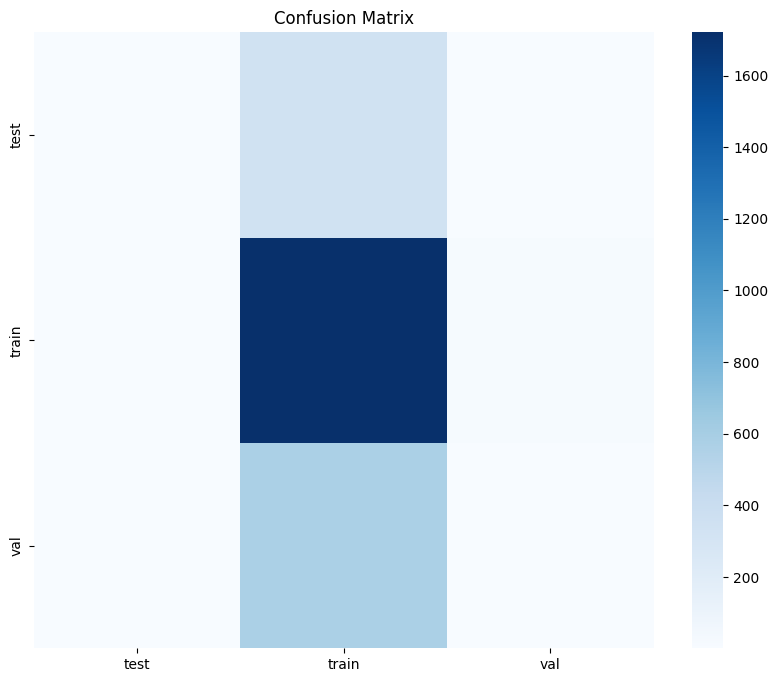

In [ ]:
print("📊 Membuat Laporan Evaluasi...")


y_true = []
y_pred = []


for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Tampilkan Report
print("\n" + classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.show()